In [1]:
!pip3 install scanpy

In [2]:
import anndata as ad
import scanpy as sc
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from scipy.stats import mode
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from collections import Counter

In [3]:
adata = ad.read_h5ad('E9.5_E1S1.MOSTA.h5ad')

In [4]:
print(adata)


AnnData object with n_obs × n_vars = 5913 × 25568
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'annotation', 'Regulon - 2310011J03Rik', 'Regulon - 5730507C01Rik', 'Regulon - Alx1', 'Regulon - Alx3', 'Regulon - Alx4', 'Regulon - Ar', 'Regulon - Arid3a', 'Regulon - Arid3c', 'Regulon - Arnt2', 'Regulon - Arx', 'Regulon - Ascl1', 'Regulon - Atf1', 'Regulon - Atf4', 'Regulon - Atf5', 'Regulon - Atf6', 'Regulon - Atf7', 'Regulon - Bach1', 'Regulon - Bach2', 'Regulon - Barhl1', 'Regulon - Barx1', 'Regulon - Batf', 'Regulon - Bcl11a', 'Regulon - Bcl3', 'Regulon - Bcl6', 'Regulon - Bcl6b', 'Regulon - Bclaf1', 'Regulon - Bdp1', 'Regulon - Bhlha15', 'Regulon - Bhlhe22', 'Regulon - Bhlhe23', 'Regulon - Bhlhe41', 'Regulon - Bmyc', 'Regulon - Boll', 'Regulon - Bptf', 'Regulon - Brca1', 'Regulon - Brf1', 'Regulon - Brf2', 'Regulon - Bsx', 'Regulon - Cdx1', 'Regulon - Cdx2', 'Regulon - Cebpa', 'Regulon - Cebpz', 'Regulon - Chd1', 'Regulon - Clock', 'Re

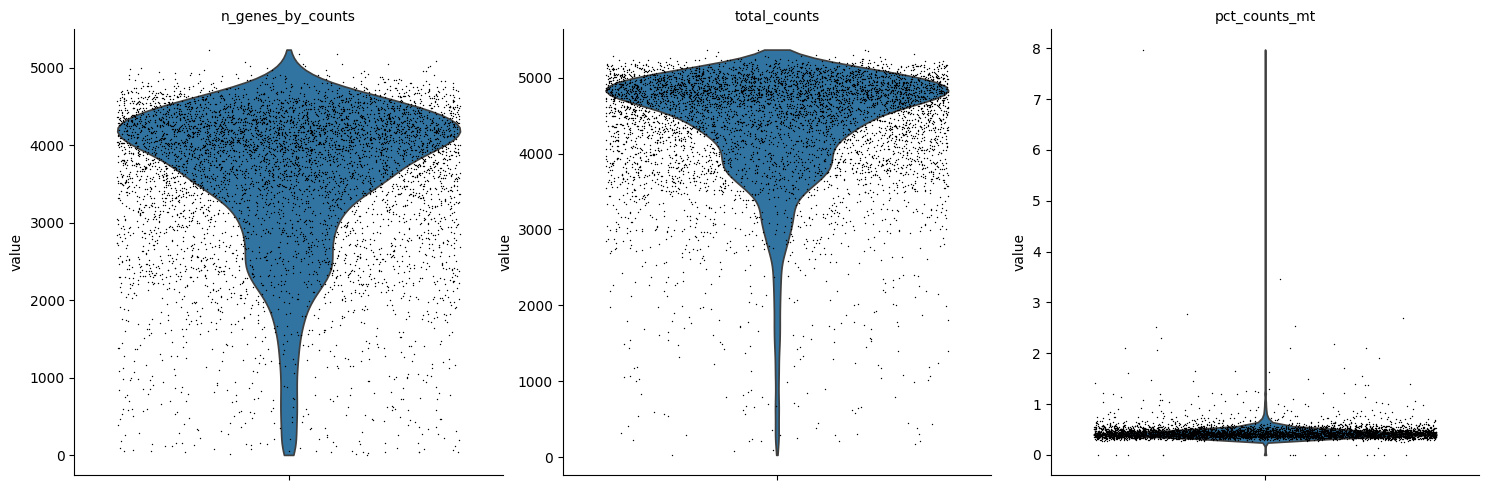

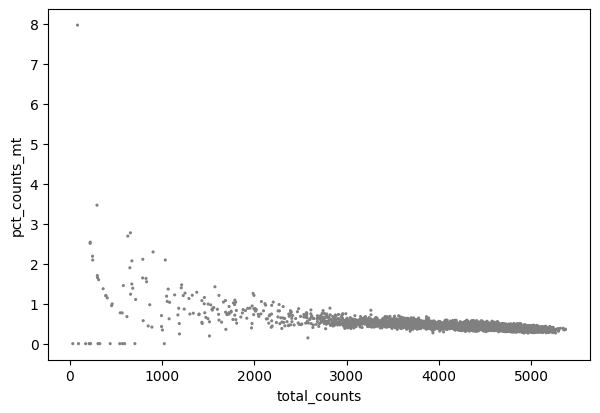

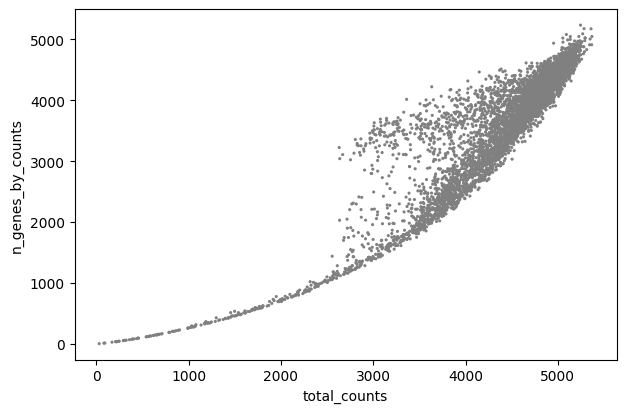

In [5]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], jitter=0.4, multi_panel=True)
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

In [6]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata = adata[adata.obs.pct_counts_mt < 2, :]

In [8]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [10]:
# Identify the highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

In [11]:
# Regress and scale the data
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

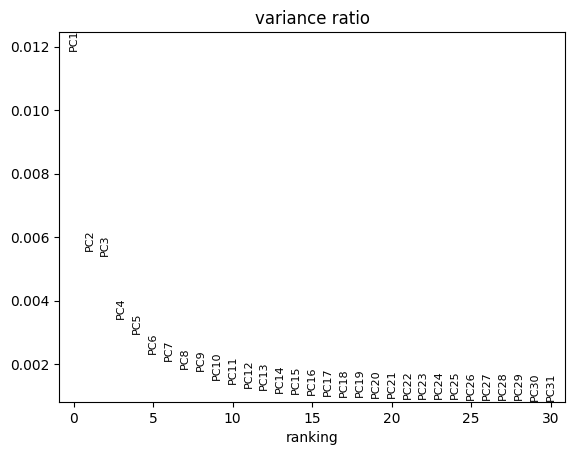

In [12]:
# Generate PCA features
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata)


In [13]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the spatial coordinates
spatial_coords = adata.obsm['spatial']
spatial_coords_standardized = scaler.fit_transform(spatial_coords)


# Fit and transform the PCA features
pca_features = adata.obsm['X_pca']
pca_features_standardized = scaler.fit_transform(pca_features)

# Concatenate the standardized PCA features and spatial coordinates
X = scaler.fit_transform(np.hstack([pca_features_standardized, spatial_coords_standardized]))

Y = adata.obs['annotation'].to_numpy()
cell_Indexes = adata.obs.index.to_numpy()

# Generate a permutation of index array
np.random.seed(42)
indices = np.arange(X.shape[0])
np.random.shuffle(indices)

# Shuffle X and Y and Cell_Indexes using the same indices
X_shuffled = X[indices]
Y_shuffled = Y[indices]
cell_Indexes_shuffled = cell_Indexes[indices]

In [14]:
# Define the number of folds and L value
k_fold = 5
combination_num = 3

K_list = [3, 5, 7]
L_list = [2, 3, 4]

# Initialize StratifiedKFold and classifier
skf = StratifiedKFold(n_splits=k_fold)

classifier1 = SVC(kernel='rbf', C=1.0, gamma='scale')  
classifier2 = RandomForestClassifier(n_estimators=100, max_depth=None, max_features="sqrt")
classifier3 = KNeighborsClassifier(n_neighbors=10)
classifier4 = GradientBoostingClassifier(n_estimators=20, max_depth=5, learning_rate=1) 
classifier5 = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=5000)  
classifier6 = RandomForestClassifier(n_estimators=200, max_depth=10, max_features="log2")
classifier7 = GradientBoostingClassifier(n_estimators=50, max_depth=3, learning_rate=0.5) 
classifiers = [classifier1, classifier2, classifier3, classifier4, classifier5, classifier6, classifier7]
classifiers_names = ["SVC", "Random Forest (max_depth=None)", "KNeighbors", "Gradient Boosting (n_estimators=20)", "LogisticRegression", 
                     "Random Forest (max_depth=10)", "Gradient Boosting (n_estimators=50)"]

In [15]:
for i in range(0,combination_num):
    K = K_list[i]
    L = L_list[i]

    # Initialize predictions dictionary with keys as cell indexes and values as empty lists or arrays of size K
    predictions = {index: np.empty(K, dtype=object) for index in cell_Indexes_shuffled}

    # Metrics storage
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    # Training and prediction
    classifier_index = 0
    for classifier_index in range(0,K):
        for train_index, test_index in skf.split(X_shuffled, Y_shuffled):
            X_train, X_test = X_shuffled[train_index], X_shuffled[test_index]
            y_train, y_test = Y_shuffled[train_index], Y_shuffled[test_index]
            cell_indexes_test = cell_Indexes_shuffled[test_index]

            classifier = classifiers[classifier_index]

            # Train the model
            classifier.fit(X_train, y_train)
            
            # Predict on the test set
            preds = classifier.predict(X_test)

            # Store predictions in the dictionary using the cell indexes
            for idx, cell_index in enumerate(cell_indexes_test):
                predictions[cell_index][classifier_index] = preds[idx]
            
            # Evaluate predictions
            acc = accuracy_score(y_test, preds, zero_division=1)
            prec = precision_score(y_test, preds, average='macro', zero_division=1)
            rec = recall_score(y_test, preds, average='macro', zero_division=1)
            f1 = f1_score(y_test, preds, average='macro', zero_division=1)

            # Print metrics
            print(f"{classifiers_names[classifier_index]} - Accuracy: {acc}, Precision: {prec}, Recall: {rec}, F1 Score: {f1}")

            # Append metrics to lists for average calculation later
            accuracy_scores.append(acc)
            precision_scores.append(prec)
            recall_scores.append(rec)
            f1_scores.append(f1)
        print("--------------------------------------------------------------------------------------------------------------------------------------------")

    # Calculate and print average scores
    print("Average Accuracy:", np.mean(accuracy_scores))
    print("Average Precision:", np.mean(precision_scores))
    print("Average Recall:", np.mean(recall_scores))
    print("Average F1 Score:", np.mean(f1_scores))

    predicted_annotations = adata.obs['annotation'].copy()

    number_of_changed = 0
    # Process each cell index and its predictions
    for cell_index, preds in predictions.items():
        # Count occurrences of each annotation
        pred_count = Counter(preds)

        most_common_pred, count = pred_count.most_common(1)[0]

        
        if count > L:
            if adata.obs.loc[cell_index, 'annotation'] != most_common_pred:
                predicted_annotations.loc[cell_index] = most_common_pred
                number_of_changed += 1

    print(f"Number of annotations changed for K={K}, L={L}: {number_of_changed}")
    print("<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>")

    adata.obs[f'annotation_K{K}_L{L}'] = predicted_annotations


SVC - Accuracy: 0.8875638841567292, Precision: 0.894562888729423, Recall: 0.8733318405079867, F1 Score: 0.8830505909235776
SVC - Accuracy: 0.8969335604770017, Precision: 0.8905417295994787, Recall: 0.8791156820114973, F1 Score: 0.884043287562302
SVC - Accuracy: 0.9045996592844975, Precision: 0.9200386679905731, Recall: 0.8858992602719932, F1 Score: 0.9006471707005702
SVC - Accuracy: 0.9028960817717206, Precision: 0.9076081432282388, Recall: 0.9026397339814958, F1 Score: 0.9042579319082923
SVC - Accuracy: 0.8901192504258943, Precision: 0.9167532125507335, Recall: 0.8710708609120886, F1 Score: 0.890833820354236
--------------------------------------------------------------------------------------------------------------------------------------------
Random Forest (max_depth=None) - Accuracy: 0.9148211243611585, Precision: 0.9218181106387596, Recall: 0.8918764083574234, F1 Score: 0.9043772765853473
Random Forest (max_depth=None) - Accuracy: 0.9173764906303237, Precision: 0.916221952982188

/Users/dejandraskovic/Desktop/Master/GI/Project/Genomics/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Gradient Boosting (n_estimators=10) - Accuracy: 0.013628620102214651, Precision: 0.04441331128789624, Recall: 0.006238110484822469, F1 Score: 0.005266159884615232
Gradient Boosting (n_estimators=10) - Accuracy: 0.8049403747870528, Precision: 0.8114928806063015, Recall: 0.7834001172007062, F1 Score: 0.7919825168054077
--------------------------------------------------------------------------------------------------------------------------------------------
LogisticRegression - Accuracy: 0.8415672913117547, Precision: 0.8565298371679578, Recall: 0.8480264691715075, F1 Score: 0.8508390308571587
LogisticRegression - Accuracy: 0.8458262350936968, Precision: 0.849413229674572, Recall: 0.8579300297646468, F1 Score: 0.8529722692663363
LogisticRegression - Accuracy: 0.8304940374787053, Precision: 0.8352070480138679, Recall: 0.8250424356579008, F1 Score: 0.8268412509833056
LogisticRegression - Accuracy: 0.8475298126064736, Precision: 0.8559611810725859, Recall: 0.8703071470826701, F1 Score: 0.85

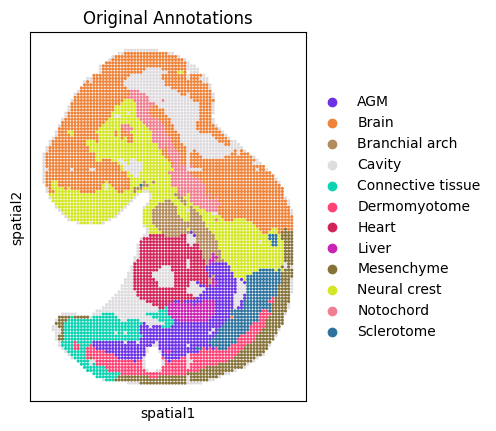

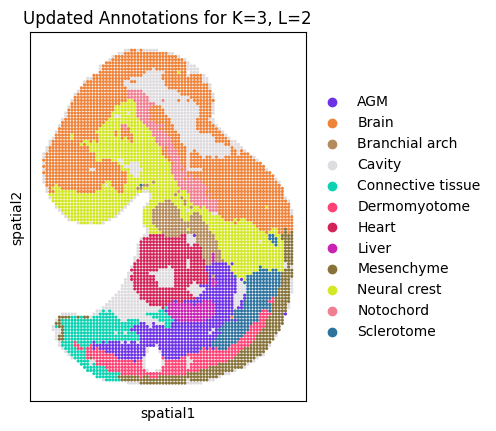

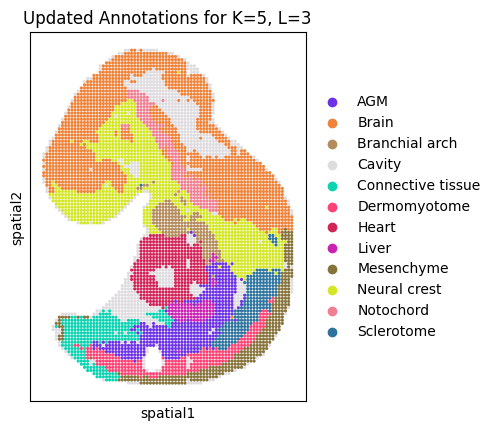

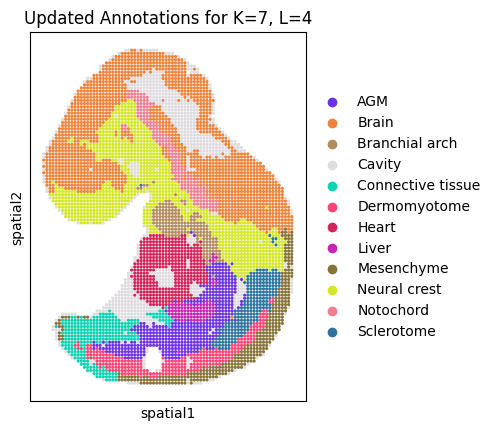

In [16]:
spot_size = 1.0  # Adjust this value as needed
existing_palette = adata.uns['annotation_colors']
sc.pl.spatial(adata, color='annotation', title=f"Original Annotations", spot_size=spot_size)

for i in range(0,combination_num):
    K = K_list[i]
    L = L_list[i]
    
    adata.uns[f'annotation_K{K}_L{L}_colors'] = existing_palette
    sc.pl.spatial(adata, color=f'annotation_K{K}_L{L}', title=f"Updated Annotations for K={K}, L={L}", spot_size=spot_size)